In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime as dt
import random

In [2]:
pd.set_option('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None)
pd.options.mode.chained_assignment = None

In [3]:
config = "1tls_3x3"

In [4]:
df_dqn_con = pd.read_csv(f'./{config}/con/DuelingDoubleDQNAgent_lr0.0001.csv', delimiter=',').assign(id=lambda df: df['id']+'_con', con=True)
df_maxpressure_con = pd.read_csv(f'./{config}/con/MaxPressureBaseline.csv', delimiter=',').assign(id=lambda df: df['id']+'_con', con=True)
df_sotl_con = pd.read_csv(f'./{config}/con/SotlBaseline.csv', delimiter=',').assign(id=lambda df: df['id']+'_con', con=True)
df_uniform_con = pd.read_csv(f'./{config}/con/UniformBaseline.csv', delimiter=',').assign(id=lambda df: df['id']+'_con', con=True)
"""
df_dqn_def = pd.read_csv(f'./{config}/def/DuelingDoubleDQNAgent_lr0.0001.csv', delimiter=',').assign(id=lambda df: df['id']+'_def', con=False)
df_maxpressure_def = pd.read_csv(f'./{config}/def/MaxPressureBaseline.csv', delimiter=',').assign(id=lambda df: df['id']+'_def', con=False)
df_sotl_def = pd.read_csv(f'./{config}/def/SotlBaseline.csv', delimiter=',').assign(id=lambda df: df['id']+'_def', con=False)
df_uniform_def = pd.read_csv(f'./{config}/def/UniformBaseline.csv', delimiter=',').assign(id=lambda df: df['id']+'_def', con=False)
"""
None

In [5]:
df_dqn_con.head(10)

,l,r,id,ep,con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_queue_length,TimeLimit.truncated,done,con
0,1,0.000000,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",10,5.837654,0.0,0,0.583765,0.000000,0.000000,False,False,True
1,2,0.000000,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",13,5.519572,0.0,0,0.424582,0.000000,0.000000,False,False,True
2,3,0.000000,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",18,11.035388,26.0,3,0.613077,1.444444,0.250000,False,False,True
3,4,0.000000,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",22,14.849798,102.0,6,0.674991,4.636364,0.500000,False,False,True
4,5,0.000202,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",22,14.472576,172.0,7,0.657844,7.818182,0.583333,False,False,True
5,6,0.000202,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",23,16.025969,235.0,9,0.696781,10.217391,0.750000,False,False,True
6,7,0.000202,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",27,20.584691,343.0,13,0.762396,12.703704,1.083333,False,False,True
7,8,0.000202,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",29,22.637172,487.0,16,0.780592,16.793103,1.333333,False,False,True
8,9,0.000202,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",31,23.181837,301.0,11,0.747801,9.709677,0.916667,False,False,True
9,10,0.181327,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",27,18.475097,194.0,9,0.684263,7.185185,0.750000,False,False,True


In [6]:
dfs = [df_dqn_con, df_maxpressure_con, df_sotl_con, df_uniform_con] # , df_dqn_def, df_maxpressure_def, df_sotl_def, df_uniform_def]

In [7]:
for df in dfs:
    display(df.loc[df["done"] == True].head(2))

,l,r,id,ep,con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_queue_length,TimeLimit.truncated,done,con
299,300,84.738664,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",37,30.508629,3763.0,22,0.824558,101.702703,1.833333,False,True,True
617,318,114.218432,rlcontroller_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",81,73.429016,7054.0,52,0.906531,87.086420,4.333333,False,True,True


,l,r,id,ep,con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_queue_length,TimeLimit.truncated,done,con
263,264,0.0,maxpressurebaseline_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",27,19.034108,464.0,12,0.704967,17.185185,1.000000,False,True,True
545,282,0.0,maxpressurebaseline_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",41,34.096772,4592.0,28,0.831629,112.000000,2.333333,False,True,True


,l,r,id,ep,con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_queue_length,TimeLimit.truncated,done,con
292,293,0.0,sotlbaseline_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",189,183.000498,4860.0,144,0.968257,25.714286,12.00,False,True,True
611,319,0.0,sotlbaseline_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",117,112.412626,1165.0,81,0.960792,9.957265,6.75,False,True,True


,l,r,id,ep,con_p_rate,veh_n_p_hour,veh_n,sum_delay,sum_waiting_time,sum_queue_length,avg_delay,avg_waiting_time,avg_queue_length,TimeLimit.truncated,done,con
239,240,0.0,uniformbaseline_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",110,102.707175,2078.0,87,0.933702,18.890909,7.250000,False,True,True
479,240,0.0,uniformbaseline_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",94,89.115024,1436.0,71,0.948032,15.276596,5.916667,False,True,True


In [8]:
def sum_ep(df):
    return pd.merge(
        df[['id', 'ep', 'veh_n', 'sum_delay', 'sum_waiting_time', 'sum_queue_length']].groupby(['ep']).sum(),
        df[['id', 'ep', 'con_p_rate', 'veh_n_p_hour', 'con']].groupby(['ep']).apply(lambda df: df.head(1)),
        how='left', left_index=True, right_index=True
    ).reset_index(drop=True)

def sum_df_ep(dfs):
    return pd.concat([sum_ep(df) for df in dfs]).sort_values(['ep', 'id']).reset_index(drop=True)

In [9]:
def avg_ep(df):
    return pd.merge(
        df[['id', 'ep', 'veh_n', 'avg_delay', 'avg_waiting_time', 'avg_queue_length']].groupby(['ep']).mean(),
        df[['id', 'ep', 'con_p_rate', 'veh_n_p_hour', 'con']].groupby(['ep']).apply(lambda df: df.head(1)),
        how='left', left_index=True, right_index=True
    ).reset_index(drop=True)

def avg_df_ep(dfs):
    return pd.concat([avg_ep(df) for df in dfs]).sort_values(['ep', 'id']).reset_index(drop=True)

In [10]:
sum_df = sum_df_ep(dfs)
avg_df = avg_df_ep(dfs)

In [11]:
display(sum_df.head(12))
display(avg_df.head(12))

,veh_n,sum_delay,sum_waiting_time,sum_queue_length,id,ep,con_p_rate,veh_n_p_hour,con
0,7452,5476.671238,162262.0,3218,maxpressurebaseline_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",True
1,12231,9974.559985,639475.0,6944,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",True
2,39477,37596.127634,1260712.0,28667,sotlbaseline_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",True
3,21163,19630.189134,287377.0,14062,uniformbaseline_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",True
4,10442,8703.617460,721067.0,6410,maxpressurebaseline_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",True
5,21940,19986.314203,7174509.0,17016,rlcontroller_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",True
6,31712,30127.628536,331061.0,21174,sotlbaseline_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",True
7,18717,17396.580401,260579.0,12590,uniformbaseline_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",True
8,21411,18669.528696,521219.0,12757,maxpressurebaseline_con,3,0.4,"[1000.0, 900.0, 300.0, 600.0]",True
9,15538,12359.924345,369449.0,7921,rlcontroller_con,3,0.4,"[1000.0, 900.0, 300.0, 600.0]",True


,veh_n,avg_delay,avg_waiting_time,avg_queue_length,id,ep,con_p_rate,veh_n_p_hour,con
0,28.227273,0.730131,20.665455,1.015783,maxpressurebaseline_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",True
1,40.770000,0.807624,51.657742,1.928889,rlcontroller_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",True
2,134.733788,0.930051,26.939998,8.153299,sotlbaseline_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",True
3,88.179167,0.909160,12.994183,4.882639,uniformbaseline_con,1,0.3,"[1000.0, 200.0, 500.0, 200.0]",True
4,37.028369,0.819691,58.770887,1.894208,maxpressurebaseline_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",True
5,68.993711,0.891326,255.079556,4.459119,rlcontroller_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",True
6,99.410658,0.936730,10.137547,5.531348,sotlbaseline_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",True
7,77.987500,0.912621,13.372950,4.371528,uniformbaseline_con,2,0.1,"[200.0, 200.0, 600.0, 300.0]",True
8,84.295276,0.852837,22.535058,4.185367,maxpressurebaseline_con,3,0.4,"[1000.0, 900.0, 300.0, 600.0]",True
9,53.030717,0.791595,23.534463,2.252844,rlcontroller_con,3,0.4,"[1000.0, 900.0, 300.0, 600.0]",True


In [16]:
###################################################################################################################

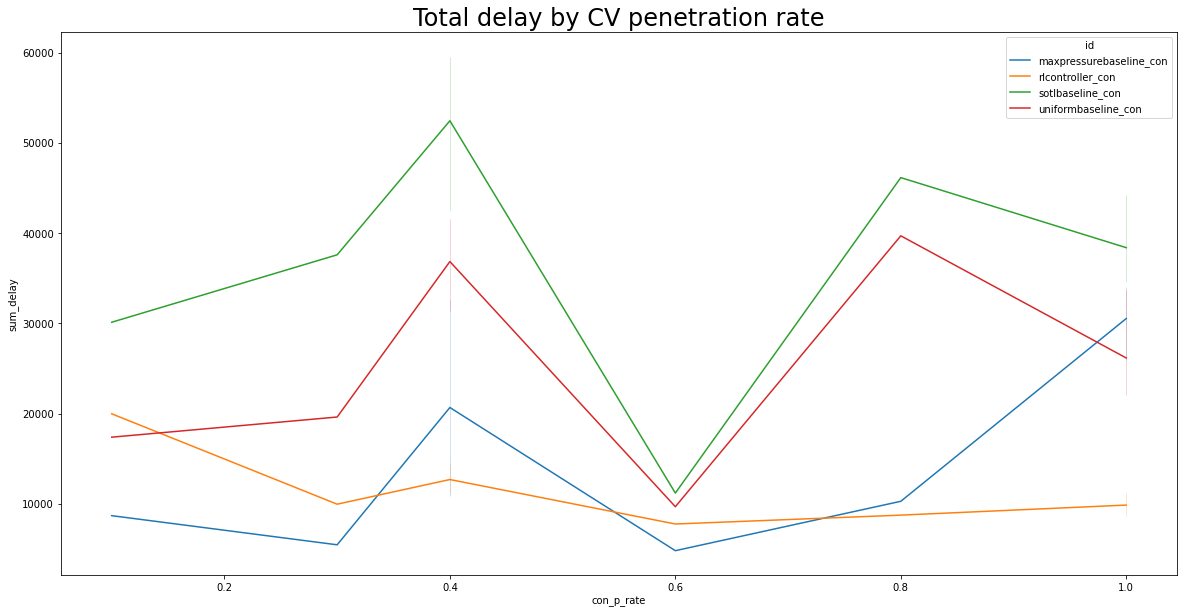

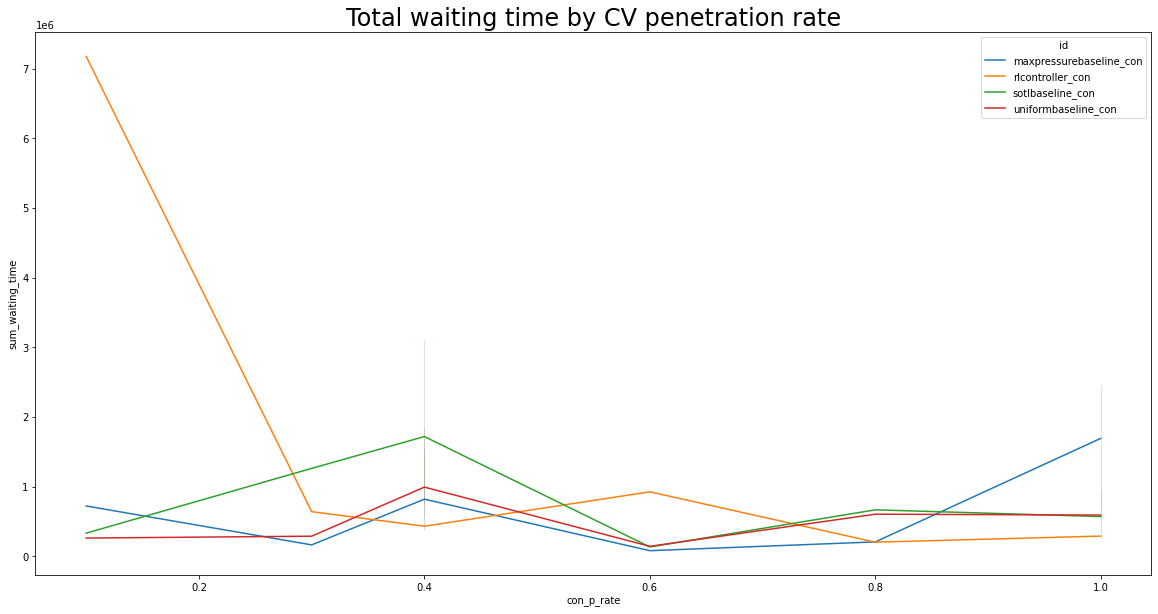

In [14]:
def plot_sum_y_by_pcon(y, title):
    plt.figure(figsize=(20, 10))
    sns.lineplot(data=sum_df, x="con_p_rate", y=y, hue="id")
    plt.title(f'Total {title} by CV penetration rate', fontsize=24)
    None

plot_sum_y_by_pcon("sum_delay", "delay")
plot_sum_y_by_pcon("sum_waiting_time", "waiting time")
# plot_sum_y_by_pcon("sum_queue_length", "queue length")

<AxesSubplot:xlabel='con_p_rate', ylabel='sum_waiting_time'>

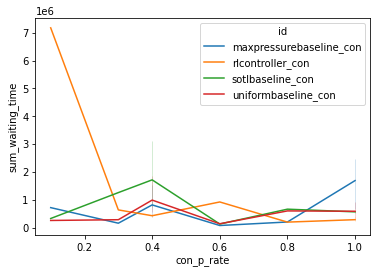

In [15]:
sns.lineplot(data=sum_df, x="con_p_rate", y="sum_waiting_time", hue="id")